# Fairness Analysis 

In [52]:
biasAttribute = 'V1_sex'
#biasAttribute = 'V4_area_origin'

#### Load dependencies

In [53]:
import torch

import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.data.dataloader import CatalanJuvenileJustice
from src.models.model import FullyConnected, AutoEncoder

from src.evaluation.utils import load_model, set_seed
from src.evaluation.visualization import FairnessVisualizer

plt.style.use('ggplot')
sns.set(font_scale=1.0)
sns.set_style('darkgrid')

In [54]:
DATA_DIR    = "../../data" 
MODEL_DIR   = "../../models"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model trained with access to sensitive attributes

In [55]:
experiment_name = 'modelv1.0-AutoEncoder-excluding_sensitive_data.lr=1e-4'

#### Load experiment from training file

In [56]:
# Load experiment file
experiment = torch.load(f"{MODEL_DIR}/{experiment_name}/best.ckpt")

# Set random seed
set_seed(experiment['seed'])

# Load dataset
dataset = CatalanJuvenileJustice(
    data_path=f"{DATA_DIR}/processed/{experiment['data']['filename']}"
)

# Get test split
train_loader, _, test_loader = dataset.get_loaders(
    batch_size=experiment['training_parameters']['batch_size'], 
    shuffle=True, 
    num_workers=1, 
    test_size=experiment['data']['split']['test_proportion'], 
    val_size=experiment['data']['split']['val_proportion'], 
    split_type=experiment['data']['split']['split_type'],
)

# Load model in evaluation mode
model = load_model(experiment=experiment)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=73, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=32, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

#### Predict on test data

In [57]:
gender_idxs = {attr: i if attr in ['V1_sex_male', 'V1_sex_female'] else -1 for i, attr in enumerate(dataset.sensitive_attributes)}
origin_idxs = {attr: i if attr in ['V4_area_origin_Europe', 'V4_area_origin_Latin America', 'V4_area_origin_Maghreb', 'V4_area_origin_Other', 'V4_area_origin_Spain'] else -1 for i, attr in enumerate(dataset.sensitive_attributes)}

In [58]:
mu      = experiment['data']['standardization']['mu']
sigma   = experiment['data']['standardization']['sigma']

sensitive_data = []
preds, pred_probs, gt_labels, equals = [], [], [], []
latent_test_representations = []
gender_labels_test, origin_labels_test = [], []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(test_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        sensitive_data.extend(batch['sensitive_data'])

        # Standardize input
        inputs = (inputs - mu) / sigma
        
        # Get predictions
        outputs = model(inputs)
        y_pred = outputs['pred']
        latent_test_representations.extend(outputs['z'])

        # Store predictions
        pred_probs.extend(y_pred)
        preds.extend(y_pred >= 0.5)

        # Store ground truth labels
        gt_labels.extend(labels)
        gender_labels_test.extend(batch['sensitive_data'][:, [i != -1 for i in gender_idxs.values()]])
        origin_labels_test.extend(batch['sensitive_data'][:, [i != -1 for i in origin_idxs.values()]])

preds, pred_probs, gt_labels = torch.stack(preds), torch.stack(pred_probs), torch.stack(gt_labels)
latent_test_representations = torch.stack(latent_test_representations).cpu().numpy()

gender_labels_test = torch.stack(gender_labels_test).cpu().numpy()
origin_labels_test = torch.stack(origin_labels_test).cpu().numpy()

100%|██████████| 15/15 [00:02<00:00,  5.93it/s]


In [59]:
df = pd.DataFrame(torch.stack(sensitive_data), columns=test_loader.dataset.dataset.sensitive_attributes)
df = df.rename(columns={'V4_area_origin_Latin America': 'V4_area_origin_LatinAmerica'})

df['labels'] = gt_labels.cpu()
df['pred_probs'] = pred_probs.cpu()
df['preds'] = preds.cpu().type(torch.int)

In [60]:
print(f"Mean predictor: {1 - df['labels'].mean()}")
print(f"Trained NN: \t{(df['labels'] == df['preds']).mean()}")

Mean predictor: 0.6537634408602151
Trained NN: 	0.7129032258064516


## Visualizations

Create visualization object

In [61]:
viz = FairnessVisualizer(df, biasAttribute=biasAttribute)

### Independence 

Probability of belonging to positive class must be equal across groups. For binary classification this means that probability of negative classes also should be equal.

In [62]:
acceptance_male = len(df.loc[(df['V1_sex_male'] == 1) & (df['preds'] == 1)])
acceptance_female = len(df.loc[(df['V1_sex_female'] == 1) & (df['preds'] == 1)])
total_male = len(df.loc[(df['V1_sex_male'] == 1)])
total_female = len(df.loc[(df['V1_sex_female'] == 1)])

independence_male = acceptance_male / total_male
independence_female = acceptance_female / total_female

print('The predicted recidivism for males are:', independence_male)
print('The predicted recidivism for females are:', independence_female)

The predicted recidivism for males are: 0.23086900129701687
The predicted recidivism for females are: 0.22012578616352202


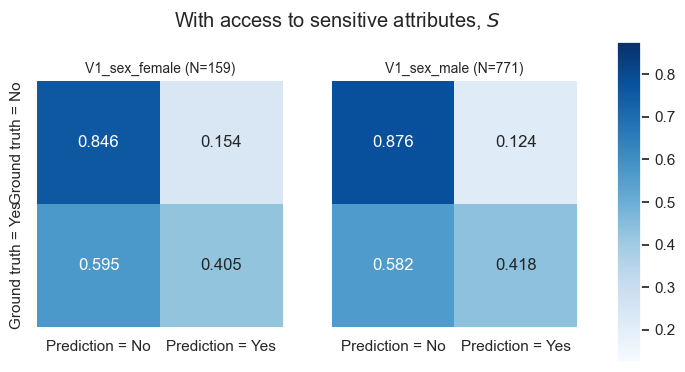

In [63]:
fig, axes, accs = viz.plot_confusion_matrices(1, 2, figsize=(8, 4), normalize=True)
fig.suptitle("With access to sensitive attributes, $S$")
plt.show()

In [47]:
from pprint import pprint
# Accuracies
print("Accuracy:\n")
pprint(accs)

Accuracy:

{'V1_sex_female': 0.7735849056603774, 'V1_sex_male': 0.728923476005188}


### Separation 

Also known as *equalized odds*. Here the FPR and TPR across sensitive attributes should add up for which reason we exploit the ROC curves.

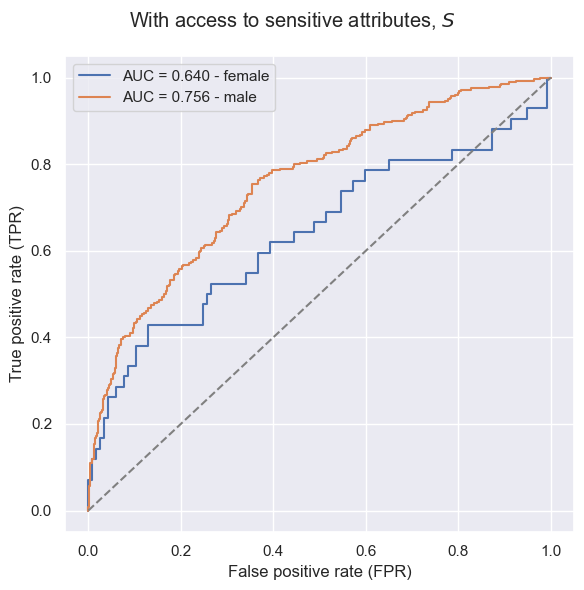

In [51]:
fig = viz.plot_roc_curve(figsize=(6,6))
fig.suptitle("With access to sensitive attributes, $S$")
plt.tight_layout()
plt.show()

### Sufficiency

Can be considered by examining whether the model is well calibrated.

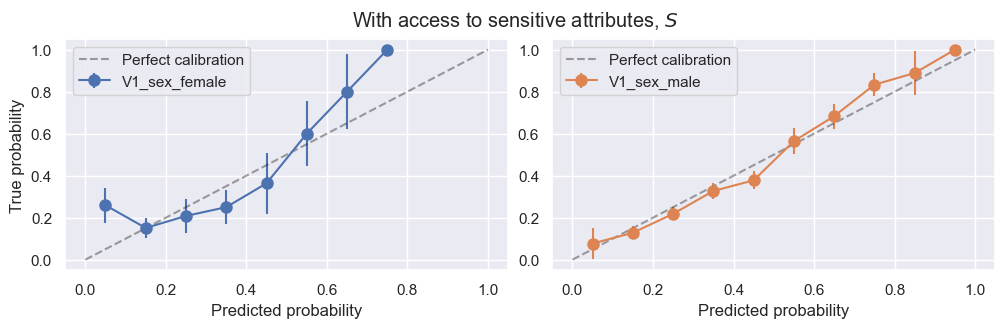

In [50]:
fig, axes = viz.plot_calibration_curves(1, 2, figsize=(12,3))
fig.suptitle("With access to sensitive attributes, $S$")
plt.show()

### Latent representations

Let's examine whether the model has learned a bias in its latent space...

In [15]:
latent_train_representations = []
gender_labels_train = []
origin_labels_train = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(train_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        # Standardize input
        inputs = (inputs - mu) / sigma

        # Get latent representations of training set
        latent_train_representations.extend(model(inputs)['z'])
        
        gender_labels_train.extend(batch['sensitive_data'][:, [i != -1 for i in gender_idxs.values()]])
        origin_labels_train.extend(batch['sensitive_data'][:, [i != -1 for i in origin_idxs.values()]])

latent_train_representations = torch.stack(latent_train_representations).cpu().numpy()
gender_labels_train = torch.stack(gender_labels_train).cpu().numpy()
origin_labels_train = torch.stack(origin_labels_train).cpu().numpy()

100%|██████████| 47/47 [00:04<00:00,  9.66it/s]


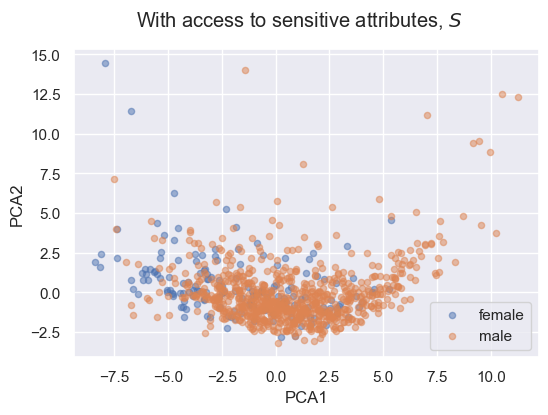

In [16]:
fig, axes = viz.plot_latent_representations(train_repr=latent_train_representations, test_repr=latent_test_representations, reduction_method='PCA', figsize=(6, 4))
fig.suptitle("With access to sensitive attributes, $S$")
plt.show()

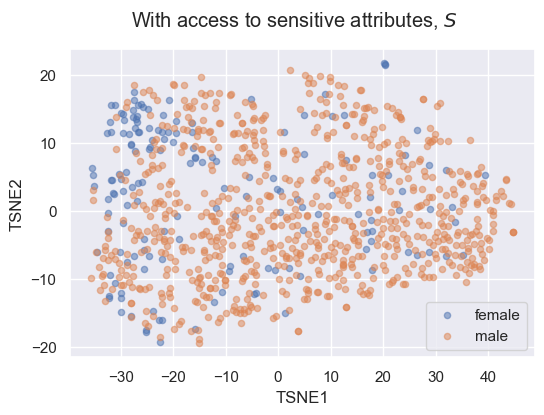

In [17]:
fig, axes = viz.plot_latent_representations(test_repr=latent_test_representations, reduction_method='TSNE', perplexity=40, figsize=(6, 4))
fig.suptitle("With access to sensitive attributes, $S$")
plt.show()

#### Testing bias of latent representations

In [18]:
from sklearn.neighbors import KNeighborsClassifier

X = latent_train_representations
y_gender = gender_labels_train.argmax(axis=1)
y_origin = origin_labels_train.argmax(axis=1)

# Gender KNN
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y_gender)
y_pred_gender = knn.predict(latent_test_representations)
y_probs_gender = knn.predict_proba(latent_test_representations)

# Area of origin KNN
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y_origin)
y_pred_origin = knn.predict(latent_test_representations)
y_probs_origin = knn.predict_proba(latent_test_representations)

In [19]:
df_gender = df.copy()
df_gender['labels'] = gender_labels_test.argmax(axis=1)
df_gender['preds'] = y_pred_gender
df_gender['pred_probs'] = y_probs_gender

df_origin = df.copy()
df_origin['labels'] = origin_labels_test.argmax(axis=1)
df_origin['preds'] = y_pred_origin
df_origin['pred_probs'] = y_probs_origin

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

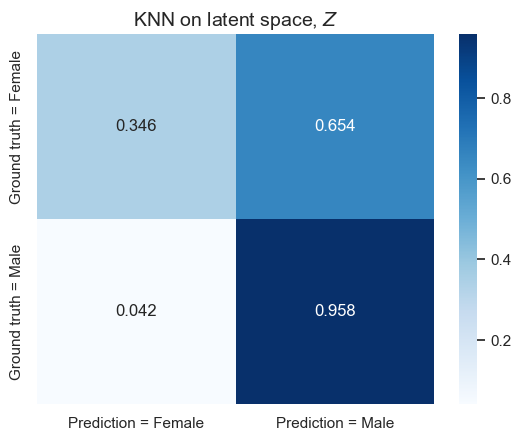

In [21]:
cm = confusion_matrix(df_gender['labels'], df_gender['preds'])

# Store accuracy of sensitive group
accuracy = np.diag(cm).sum() / np.sum(cm)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm,
    annot=True,
    fmt=".3f",
    cmap='Blues',
)

# Set ticks
plt.xticks([0.5, 1.5], ['Prediction = Female', 'Prediction = Male'])
plt.yticks([0.5, 1.5], ['Ground truth = Female', 'Ground truth = Male'])


# Set title
plt.title(f"KNN on latent space, $Z$ ", fontsize=14)
plt.show()

In [22]:
print(accuracy)

0.853763440860215


## Model trained without access to sensitive attributes

In [23]:
experiment_name = 'modelv1.0-AutoEncoder-no_sensitive_data.lr=1e-4'

#### Load experiment from training file

In [24]:
# Load experiment file
experiment = torch.load(f"{MODEL_DIR}/{experiment_name}/best.ckpt")

# Set random seed
set_seed(experiment['seed'])

# Load dataset
dataset = CatalanJuvenileJustice(
    data_path=f"{DATA_DIR}/processed/{experiment['data']['filename']}"
)

# Get test split
train_loader, _, test_loader = dataset.get_loaders(
    batch_size=experiment['training_parameters']['batch_size'], 
    shuffle=True, 
    num_workers=1, 
    test_size=experiment['data']['split']['test_proportion'], 
    val_size=experiment['data']['split']['val_proportion'], 
    split_type=experiment['data']['split']['split_type'],
)

# Load model in evaluation mode
model = load_model(experiment=experiment)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=73, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=32, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

#### Predict on test data

In [25]:
mu      = experiment['data']['standardization']['mu']
sigma   = experiment['data']['standardization']['sigma']

sensitive_data = []
preds, pred_probs, gt_labels, equals = [], [], [], []
latent_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(test_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        sensitive_data.extend(batch['sensitive_data'])

        # Standardize input
        inputs = (inputs - mu) / sigma
        # Get predictions
        outputs = model(inputs)
        y_pred = outputs['pred']
        latent_representations.extend(outputs['z'])

        # Store predictions
        pred_probs.extend(y_pred)
        preds.extend(y_pred >= 0.5)

        # Store ground truth labels
        gt_labels.extend(labels)

preds, pred_probs, gt_labels = torch.stack(preds), torch.stack(pred_probs), torch.stack(gt_labels)
latent_representations = torch.stack(latent_representations)

100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


In [26]:
mu      = experiment['data']['standardization']['mu']
sigma   = experiment['data']['standardization']['sigma']

sensitive_data = []
preds, pred_probs, gt_labels, equals = [], [], [], []
latent_test_representations = []
gender_labels_test, origin_labels_test = [], []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(test_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        sensitive_data.extend(batch['sensitive_data'])

        # Standardize input
        inputs = (inputs - mu) / sigma
        # Get predictions
        outputs = model(inputs)
        y_pred = outputs['pred']
        latent_test_representations.extend(outputs['z'])

        # Store predictions
        pred_probs.extend(y_pred)
        preds.extend(y_pred >= 0.5)

        # Store ground truth labels
        gt_labels.extend(labels)
        gender_labels_test.extend(batch['sensitive_data'][:, [i != -1 for i in gender_idxs.values()]])
        origin_labels_test.extend(batch['sensitive_data'][:, [i != -1 for i in origin_idxs.values()]])

preds, pred_probs, gt_labels = torch.stack(preds), torch.stack(pred_probs), torch.stack(gt_labels)
latent_test_representations = torch.stack(latent_test_representations).cpu().numpy()

gender_labels_test = torch.stack(gender_labels_test).cpu().numpy()
origin_labels_test = torch.stack(origin_labels_test).cpu().numpy()

100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


In [27]:
df = pd.DataFrame(torch.stack(sensitive_data), columns=test_loader.dataset.dataset.sensitive_attributes)
df = df.rename(columns={'V4_area_origin_Latin America': 'V4_area_origin_LatinAmerica'})

df['labels'] = gt_labels.cpu()
df['pred_probs'] = pred_probs.cpu()
df['preds'] = preds.cpu().type(torch.int)

In [28]:
print(f"Mean predictor: {1 - df['labels'].mean()}")
print(f"Trained NN: \t{(df['labels'] == df['preds']).mean()}")

Mean predictor: 0.6537634408602151
Trained NN: 	0.7086021505376344


## Visualizations

Create visualization object

In [29]:
viz = FairnessVisualizer(df, biasAttribute=biasAttribute)

### Independence 

Probability of belonging to positive class must be equal across groups. For binary classification this means that probability of negative classes also should be equal.

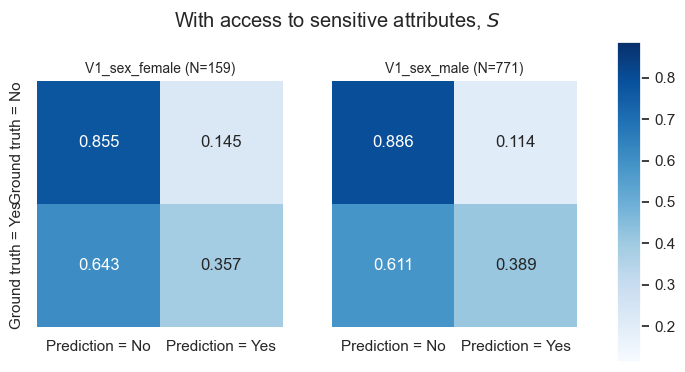

In [30]:
fig, axes, accs = viz.plot_confusion_matrices(1, 2, figsize=(8, 4), normalize=True)
fig.suptitle("Without access to sensitive attributes, $S$")
plt.show()

In [31]:
# Accuracies
print("Accuracy:\n")
pprint(accs)

Accuracy:

{'V1_sex_female': 0.7232704402515723, 'V1_sex_male': 0.7055771725032426}


### Separation 

Also known as *equalized odds*. Here the FPR and TPR across sensitive attributes should add up for which reason we exploit the ROC curves.

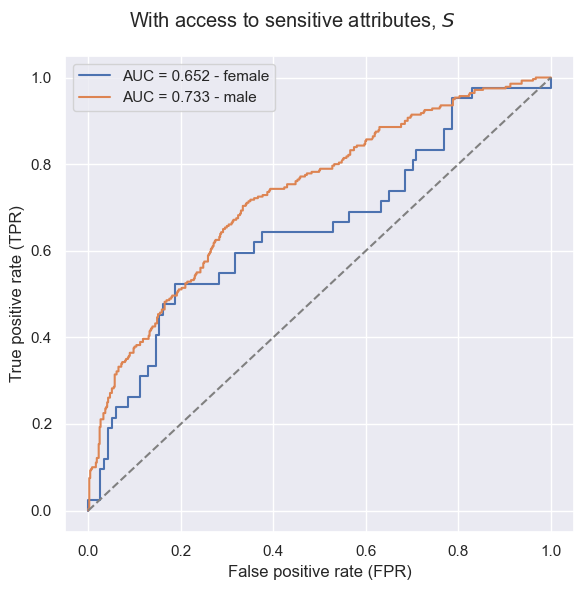

In [32]:
fig = viz.plot_roc_curve(figsize=(6,6))
fig.suptitle("Without access to sensitive attributes, $S$")
plt.tight_layout()
plt.show()

### Sufficiency

Can be considered by examining whether the model is well calibrated.

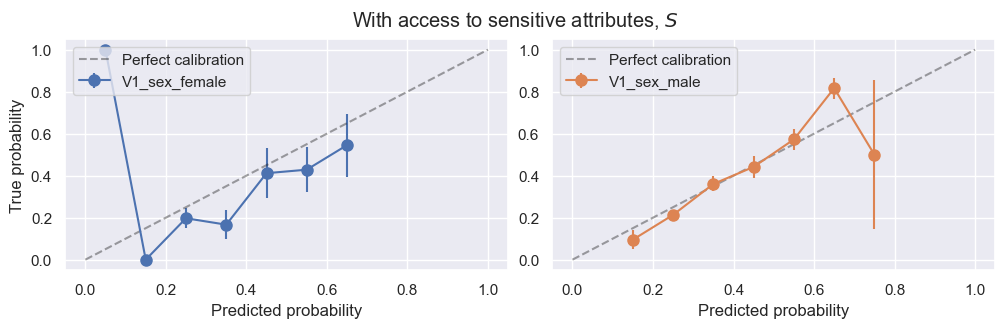

In [33]:
fig, axes = viz.plot_calibration_curves(1, 2, figsize=(12,3))
fig.suptitle("Without access to sensitive attributes, $S$")
plt.show()

### Latent representations

Let's examine whether the model has learned a bias in its latent space...

In [34]:
latent_train_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(train_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        # Standardize input
        inputs = (inputs - mu) / sigma

        # Get latent representations of training set
        latent_train_representations.extend(model(inputs)['z'])

latent_train_representations = torch.stack(latent_train_representations).cpu().numpy()

100%|██████████| 47/47 [00:04<00:00,  9.45it/s]


In [35]:
latent_train_representations = []
gender_labels_train = []
origin_labels_train = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(train_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        # Standardize input
        inputs = (inputs - mu) / sigma

        # Get latent representations of training set
        latent_train_representations.extend(model(inputs)['z'])
        
        gender_labels_train.extend(batch['sensitive_data'][:, [i != -1 for i in gender_idxs.values()]])
        origin_labels_train.extend(batch['sensitive_data'][:, [i != -1 for i in origin_idxs.values()]])

latent_train_representations = torch.stack(latent_train_representations).cpu().numpy()
gender_labels_train = torch.stack(gender_labels_train).cpu().numpy()
origin_labels_train = torch.stack(origin_labels_train).cpu().numpy()

100%|██████████| 47/47 [00:04<00:00,  9.89it/s]


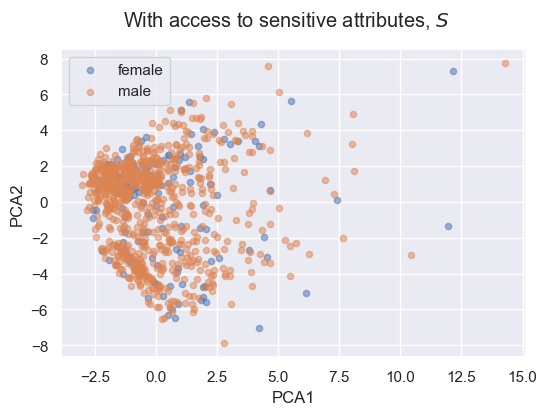

In [36]:
fig, axes = viz.plot_latent_representations(train_repr=latent_train_representations, test_repr=latent_test_representations, reduction_method='PCA', figsize=(6, 4))
fig.suptitle("Without access to sensitive attributes, $S$")
plt.show()

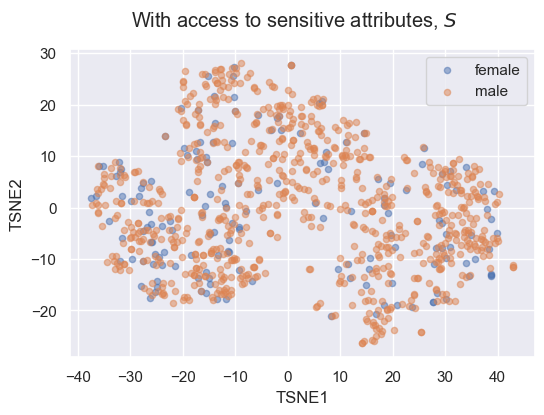

In [37]:
fig, axes = viz.plot_latent_representations(test_repr=latent_test_representations, reduction_method='TSNE', perplexity=40, figsize=(6, 4))
fig.suptitle("Without access to sensitive attributes, $S$")
plt.show()

In [38]:
from sklearn.neighbors import KNeighborsClassifier

X = latent_train_representations
y_gender = gender_labels_train.argmax(axis=1)
y_origin = origin_labels_train.argmax(axis=1)

# Gender KNN
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y_gender)
y_pred_gender = knn.predict(latent_test_representations)
y_probs_gender = knn.predict_proba(latent_test_representations)

# Area of origin KNN
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y_origin)
y_pred_origin = knn.predict(latent_test_representations)
y_probs_origin = knn.predict_proba(latent_test_representations)

In [39]:
df_gender = df.copy()
df_gender['labels'] = gender_labels_test.argmax(axis=1)
df_gender['preds'] = y_pred_gender
df_gender['pred_probs'] = y_probs_gender

df_origin = df.copy()
df_origin['labels'] = origin_labels_test.argmax(axis=1)
df_origin['preds'] = y_pred_origin
df_origin['pred_probs'] = y_probs_origin

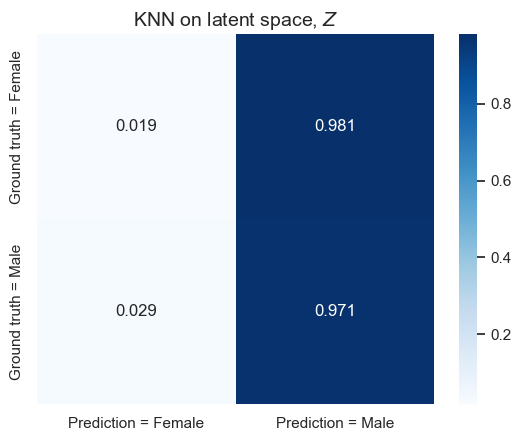

In [40]:
cm = confusion_matrix(df_gender['labels'], df_gender['preds'])

# Store accuracy of sensitive group
accuracy = np.diag(cm).sum() / np.sum(cm)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm,
    annot=True,
    fmt=".3f",
    cmap='Blues',
)

# Set ticks
plt.xticks([0.5, 1.5], ['Prediction = Female', 'Prediction = Male'])
plt.yticks([0.5, 1.5], ['Ground truth = Female', 'Ground truth = Male'])


# Set title
plt.title(f"KNN on latent space, $Z$ ", fontsize=14)
plt.show()

In [41]:
print(accuracy)

0.8086021505376344
